# Fairness and Diversity analysis for ADS using regression model

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import ADS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Fairness

In [2]:
# run the simple linear regression for multiple test sets, given the same test set size but randomly update the test size
def run_regression(_data, model_name="linear", test_ratio=0.33, run_times=100):
    sensi_group_map = {"sex":{0: "female", 1: "male"},
                       "age":{1: "young", 0: "old"},
                       "bmi":{1: "obesity", 0: "non-obesity"},
                       "children":{1: "have children", 0: "no child"},
                       "smoker":{1: "smoker", 0: "non-smoker"}}
                       
    
    att_list = sensi_group_map.keys() # get all the sensitive atts
    res_df = pd.DataFrame(columns=["run_time", "overall_acc", "sensi_att", "sensi_group", "group_acc", "group_ppv"])
    for ri in range(run_times):
        data_train, data_test = train_test_split(_data, test_size=test_ratio, random_state=ri)
        
        cur_model, overall_acc = call_regression_model(model_name, data_train, data_test)
        for ai in att_list: # compute the acc for every subpopultation
            for vi in [1, 0]:
                cur_value_data = get_value_data(data_test, vi, ai)
                cur_acc = compute_group_acc(model_name, cur_model, cur_value_data, data_test)
                cur_ppv = compute_ppv_group(model_name, cur_model, cur_value_data, data_test)
                res_df.loc[res_df.shape[0]] = [ri, overall_acc, ai, sensi_group_map[ai][vi], cur_acc, cur_ppv]
    return res_df
def call_regression_model(_model_name, _train_data, _test_data):
    if _model_name == "linear":
        r_model = ADS.simpleLR(_train_data)
        X_test, y_test = ADS.prepareLR(_test_data)
        r_msr = r_model.score(X_test, y_test)
    elif _model_name == "polynomial":
        r_model = ADS.polynomialLR(_train_data)
        X_test, y_test = ADS.preparePoly(_test_data)
        r_msr = r_model.score(X_test, y_test)
    else: # random forest
        r_model = ADS.forest(_train_data)
        X_test, y_test = ADS.prepareForest(_test_data)
        y_pred = r_model.predict(X_test)
        r_msr = r2_score(y_test, y_pred)
    return r_model, r_msr
def compute_group_acc(_model_name, _model, _group_test_data, _all_test_data):
    if _model_name == "linear":
        X_test, y_test = ADS.prepareLR(_group_test_data)
        if len(y_test) != len(_all_test_data) and len(y_test) > 0:
            return _model.score(X_test, y_test)
        else:
            return -1
    elif _model_name == "polynomial":
        X_test, y_test = ADS.preparePoly(_group_test_data)
        if len(y_test) != len(_all_test_data) and len(y_test) > 0:
            return _model.score(X_test, y_test)
        else:
            return -1
    else: # random forest
        X_test, y_test = ADS.prepareForest(_group_test_data)
        if len(y_test) != len(_all_test_data) and len(y_test) > 0:
            y_pred = _model.predict(X_test)
            return r2_score(y_test, y_pred)
        else:
            return -1
# function to compute PPV
def compute_ppv_group(_model_name, _model, _group_test_data, _all_test_data, y_threshold = 20000):
    if _model_name == "linear":
        X_test, y_test = ADS.prepareLR(_group_test_data)
    elif _model_name == "polynomial":
        X_test, y_test = ADS.preparePoly(_group_test_data)
    else: # random forest
        X_test, y_test = ADS.prepareForest(_group_test_data)
    
    if len(y_test) != len(_all_test_data) and len(y_test) > 0:
        y_pred = _model.predict(X_test)
        if  len([x for x in y_pred if x >= y_threshold]) > 0:
            if _model_name == "polynomial": # for polynomial, the data type is different
                cur_tp = len([idx for idx, x in enumerate(y_pred) if x >= y_threshold and _all_test_data.loc[_group_test_data.iloc[idx,:].name, "charges"] >= y_threshold])
                cur_fp = len([idx for idx, x in enumerate(y_pred) if x >= y_threshold and _all_test_data.loc[_group_test_data.iloc[idx,:].name, "charges"] < y_threshold])
            else:
                cur_tp = len([idx for idx, x in enumerate(y_pred) if x >= y_threshold and _all_test_data.loc[X_test.iloc[idx,:].name, "charges"] >= y_threshold])
                cur_fp = len([idx for idx, x in enumerate(y_pred) if x >= y_threshold and _all_test_data.loc[X_test.iloc[idx,:].name, "charges"] < y_threshold])
            
            if len([x for x in y_pred if x >= y_threshold]) != (cur_tp + cur_fp):
                print ("Wrong!")
            else:
                pass
            return round(cur_tp/(cur_tp+cur_fp), 2)
        else:
            return -1
    else:
        return -1
def get_value_data(_data, _value, _att):
    att_threshold_map = {"age": 25,
                       "bmi": 30,
                       "children": 0}
    # _value is 0 or 1
    if _att in ["sex", "smoker"]: # binary atts
        return _data.loc[_data[_att]==_value]
    else: # for numerical att, binarize the value by threshold
        if _att == "age":
            if _value: # for young
                return _data.loc[_data[_att] < 25]
            else: # for old
                return _data.loc[_data[_att] >= 25]
        elif _att == "bmi":
            if _value: # for obesity
                return _data.loc[_data[_att] >= 30]
            else: # for non-obesity
                return _data.loc[_data[_att] < 30]
        else: # for children
            if _value: # have children
                return _data.loc[_data[_att] > 0]
            else: # for no child
                return _data.loc[_data[_att] == 0]

## Show the performance for sub-populations
- Performance is measured by accuracy metric: mean squared error rate
- We consider 5 sensitive attributes: sex, age, bmi, children, smoker
- The sub-populations defined by above attributes are the following:
    - Sex: female and male
    - Age: young (age < 25) and old (age >= 25)
    - BMI: obesity (bmi >=30) and non-obesity (bmid < 30)
    - Children: have children (children > 0) and no child (children == 0)
    - Smoker: smoker and non-smoker

In [3]:
# input data
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
simple_res = run_regression(data, model_name="linear")
simple_res.head(5)

,run_time,overall_acc,sensi_att,sensi_group,group_acc,group_ppv
0,0,0.78737,sex,male,0.810935,0.86
1,0,0.78737,sex,female,0.743416,0.73
2,0,0.78737,age,young,0.716226,0.68
3,0,0.78737,age,old,0.802042,0.85
4,0,0.78737,bmi,obesity,0.850059,1.00


In [4]:
# input data
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
poly_res = run_regression(data, model_name="polynomial")
poly_res.head(5)

,run_time,overall_acc,sensi_att,sensi_group,group_acc,group_ppv
0,0,0.874187,sex,male,0.894276,0.89
1,0,0.874187,sex,female,0.837430,0.90
2,0,0.874187,age,young,0.809522,0.82
3,0,0.874187,age,old,0.889177,0.91
4,0,0.874187,bmi,obesity,0.911034,1.00


In [5]:
# input data
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
rf_res = run_regression(data, model_name="random")
rf_res.head(5)

,run_time,overall_acc,sensi_att,sensi_group,group_acc,group_ppv
0,0,0.860983,sex,male,0.879334,0.91
1,0,0.860983,sex,female,0.827096,0.96
2,0,0.860983,age,young,0.816758,1.00
3,0,0.860983,age,old,0.869936,0.91
4,0,0.860983,bmi,obesity,0.896974,0.97


## Compute group fairness for sub-populations
- Group fairness measure is predict positive rate PPV) by defining positive as precited charges >= 20000. 
    - There are around 20% (273/1338) population with the positive label.
- We test the group fairness given different train-test splits.

In [6]:
# input data
train_ratio_list = [x/100 for x in range(50, 100) if x%5==0]
model_list = ["linear", "polynomial", "random"]
gf_res = pd.DataFrame(columns=["train_ratio","regression_model", "run_time", "overall_acc", "sensi_att", "sensi_group", "group_acc", "group_ppv"])
for ti in train_ratio_list:
    for mi in model_list:
        data = pd.read_csv("insurance.csv")
        data = ADS.encode(data)
        cur_res = run_regression(data, model_name=mi, test_ratio=1-ti, run_times=100)
        cur_res["train_ratio"] = ti

        cur_res["regression_model"] = mi
        cur_res = cur_res.loc[:, gf_res.columns]
        gf_res = pd.concat([gf_res, cur_res])

## Visualize the accuracy of sub-populations for a given train-test split

### Linear regression

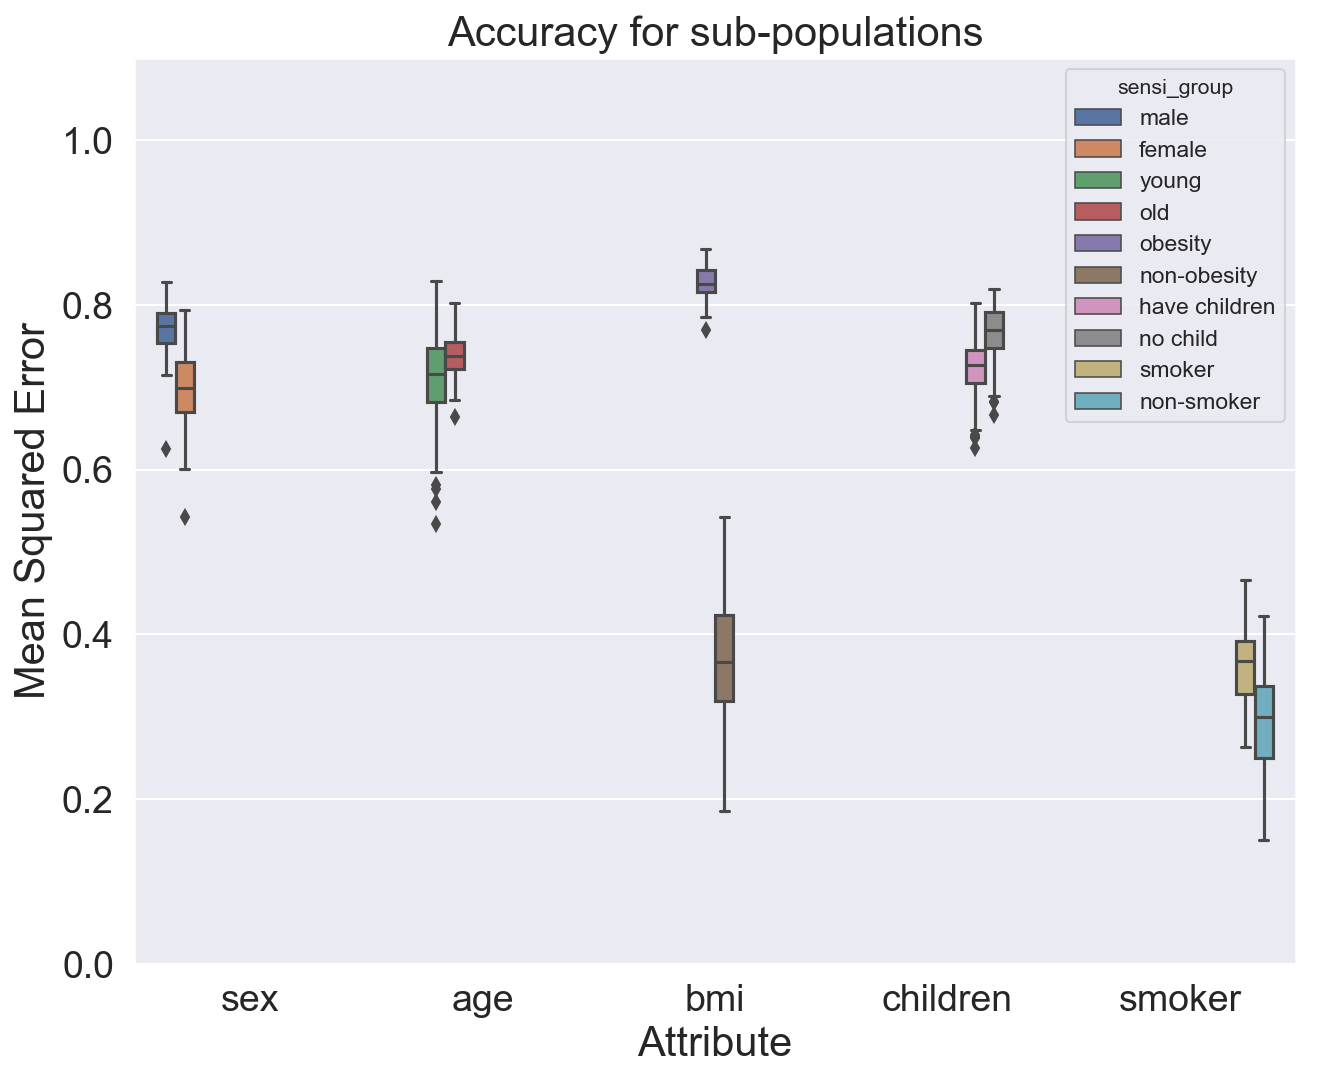

In [7]:
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="sensi_att", y="group_acc", hue="sensi_group", data=simple_res)
plt.xlabel("Attribute", fontsize=20)
plt.ylabel("Mean Squared Error", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,1.1])
plt.title("Accuracy for sub-populations", fontsize=20)
plt.savefig("Accuracy_lr.png")

### Polynomial regression

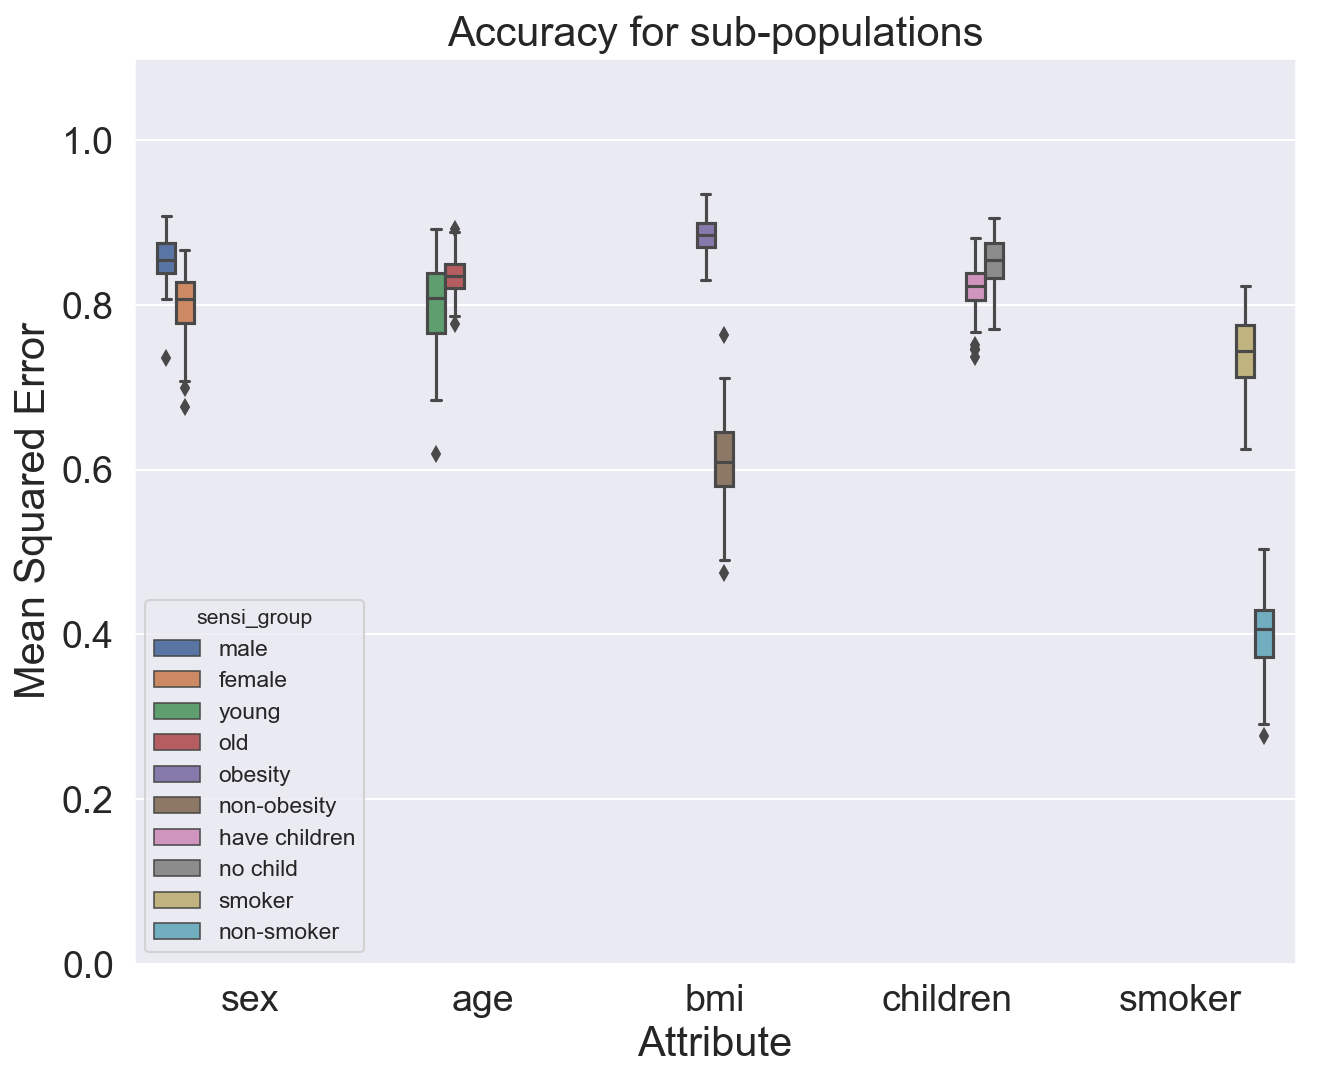

In [8]:
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="sensi_att", y="group_acc", hue="sensi_group", data=poly_res)
plt.xlabel("Attribute", fontsize=20)
plt.ylabel("Mean Squared Error", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,1.1])
plt.title("Accuracy for sub-populations", fontsize=20)
plt.savefig("Accuracy_pl.png")

### Random Forest

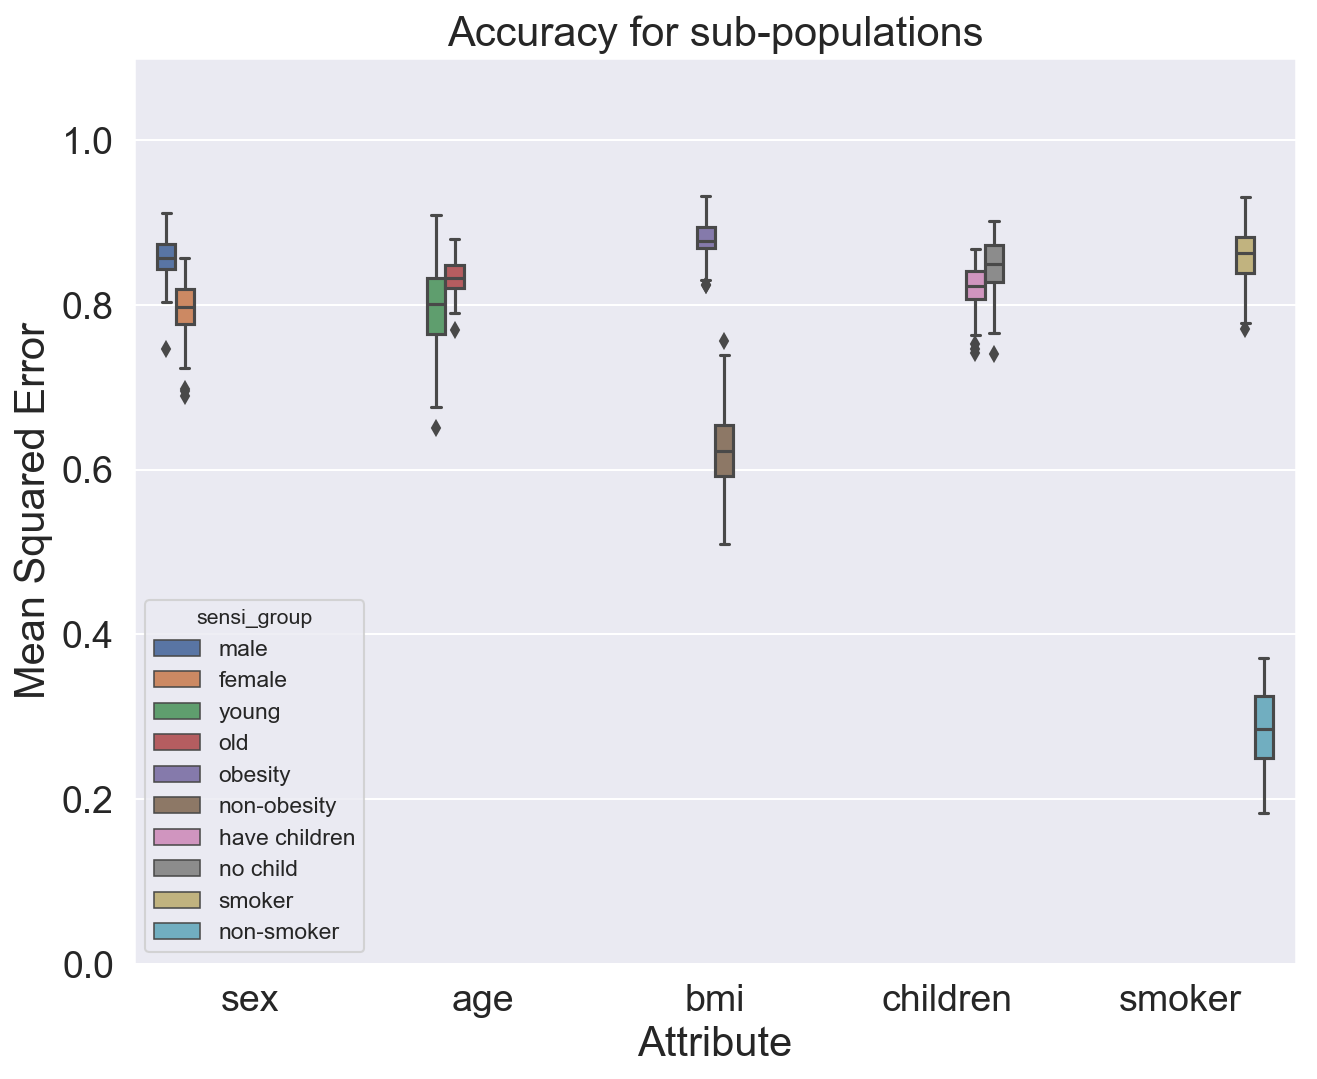

In [9]:
plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="sensi_att", y="group_acc", hue="sensi_group", data=rf_res)
plt.xlabel("Attribute", fontsize=20)
plt.ylabel("Mean Squared Error", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0,1.1])
plt.title("Accuracy for sub-populations", fontsize=20)
plt.savefig("Accuracy_rf.png")

## Visualize group fairness for different train-test splits

### Linear Regression

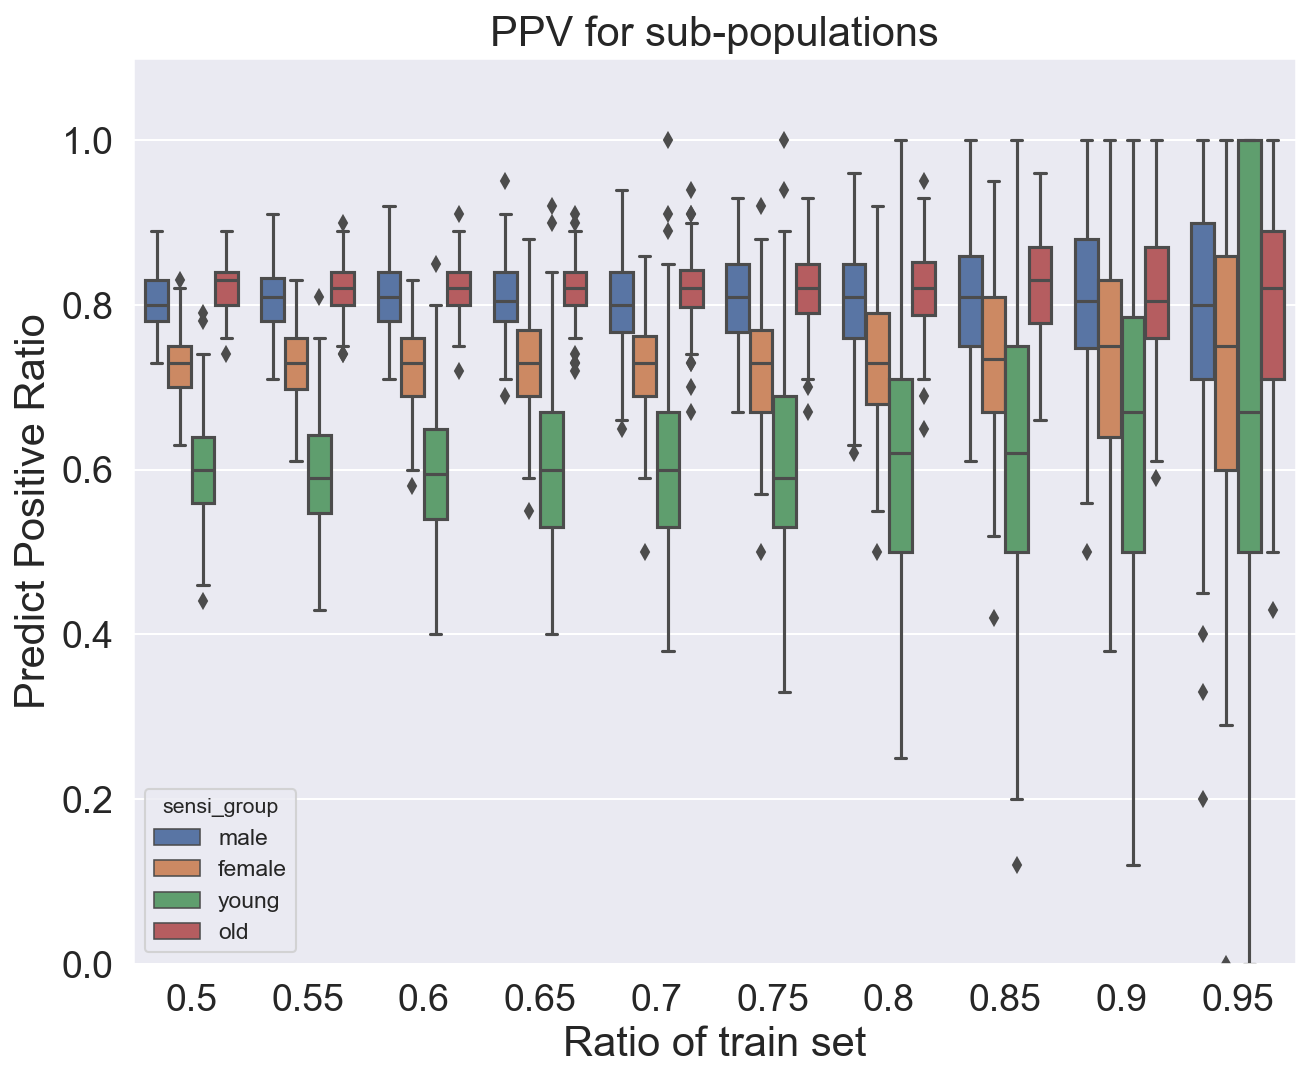

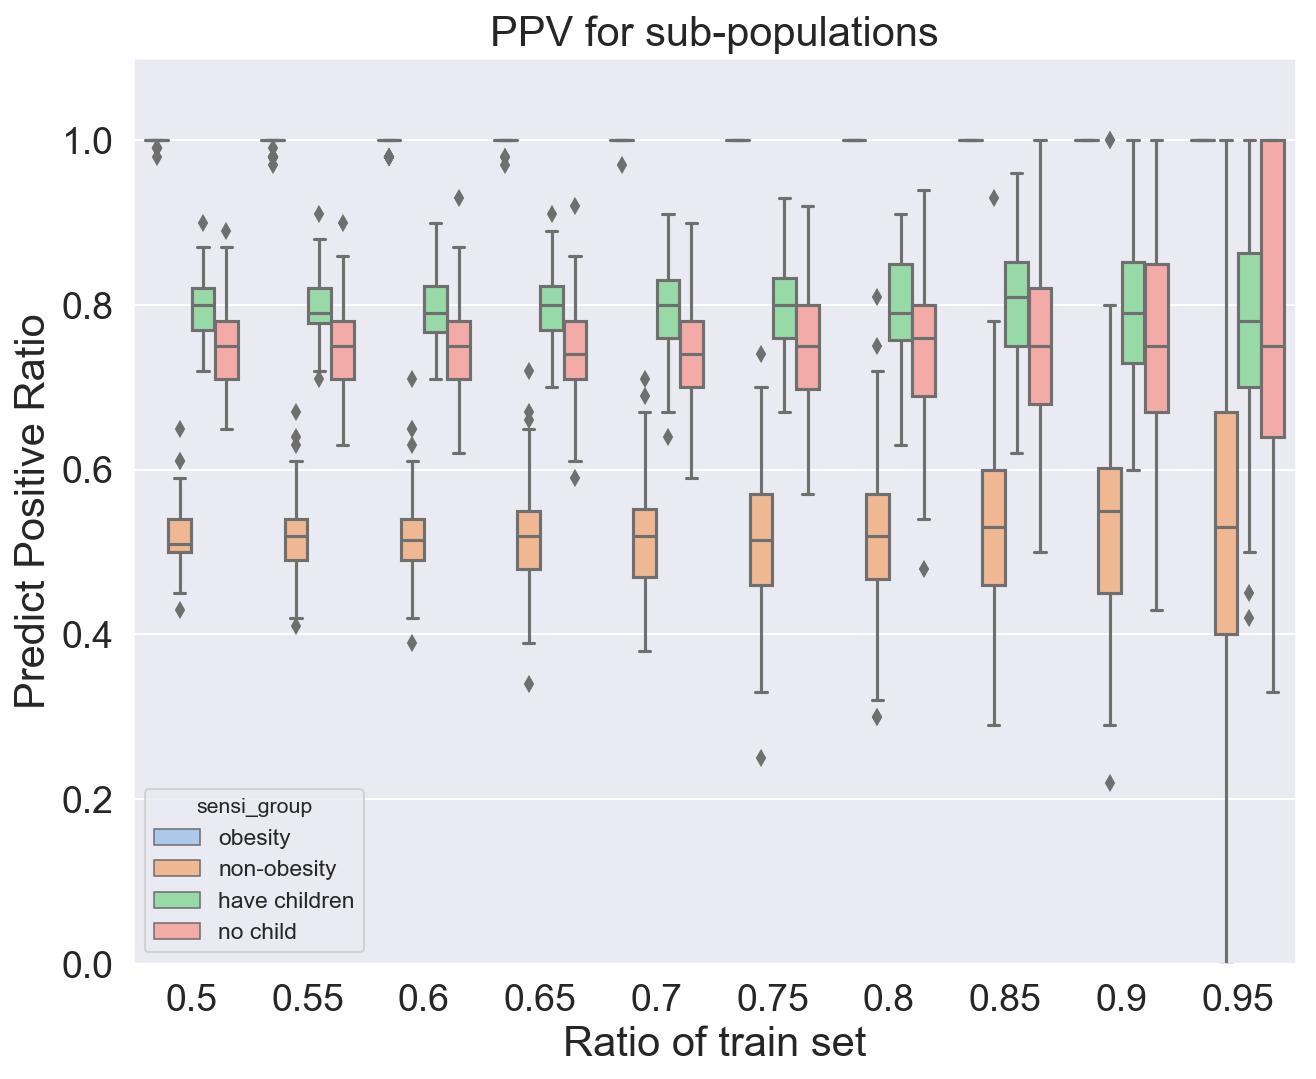

In [16]:
lr_gf_res = gf_res[(gf_res["regression_model"]=="linear") & (gf_res["group_ppv"]!=-1)]
lr_gf_1 = lr_gf_res[lr_gf_res["sensi_att"].isin(["age", "sex"])]
lr_gf_2 = lr_gf_res[lr_gf_res["sensi_att"].isin(["bmi", "children"])]

plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="train_ratio", y="group_ppv", hue="sensi_group", data=lr_gf_1)
plt.xlabel("Ratio of train set", fontsize=20)
plt.ylabel("Predict Positive Ratio", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(lr_gf_res["group_ppv"]),1.1])
plt.title("PPV for sub-populations", fontsize=20)
plt.savefig("GF_lr_1.png")

plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="train_ratio", y="group_ppv", hue="sensi_group", data=lr_gf_2, palette="pastel")
plt.xlabel("Ratio of train set", fontsize=20)
plt.ylabel("Predict Positive Ratio", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(lr_gf_res["group_ppv"]),1.1])
plt.title("PPV for sub-populations", fontsize=20)
plt.savefig("GF_lr_2.png")

### Polynomial Regression

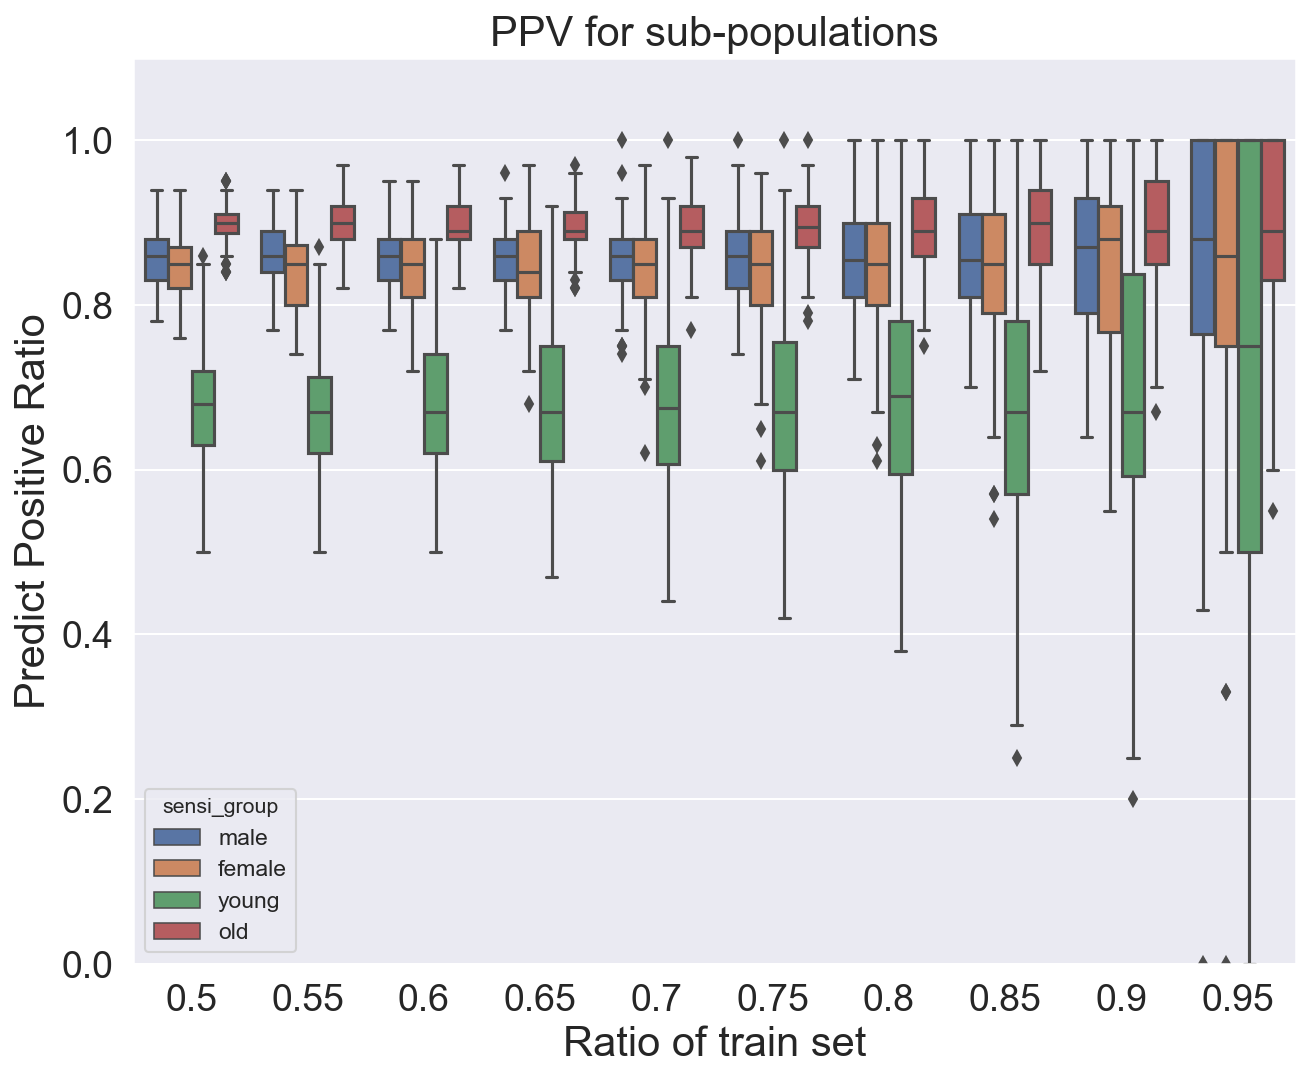

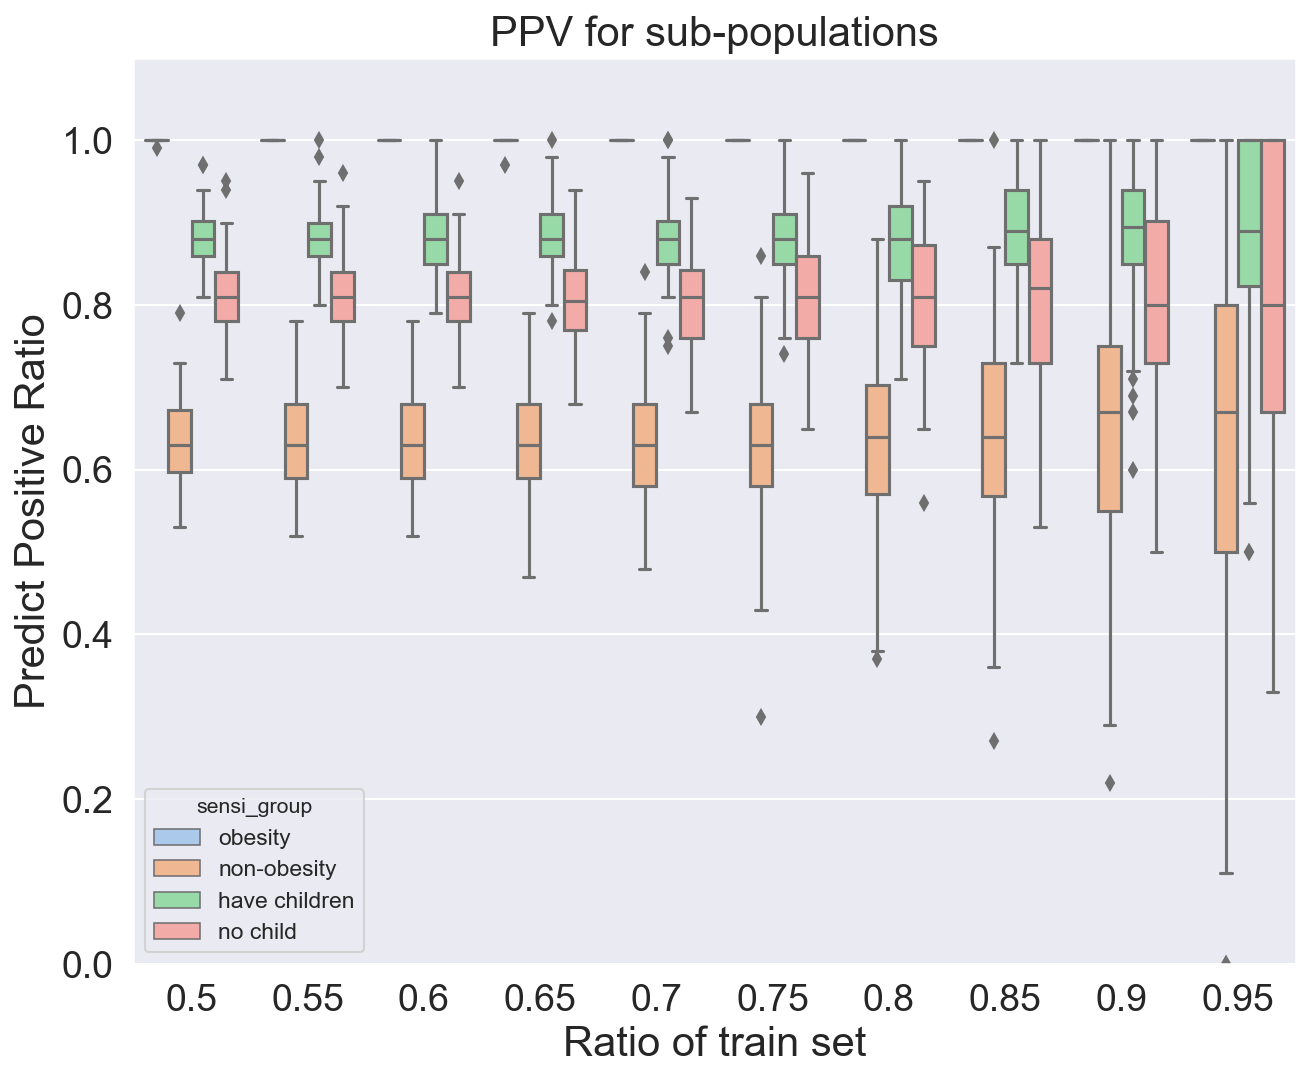

In [17]:
pl_gf_res = gf_res[(gf_res["regression_model"]=="polynomial") & (gf_res["group_ppv"]!=-1)]
pl_gf_1 = pl_gf_res[pl_gf_res["sensi_att"].isin(["age", "sex"])]
pl_gf_2 = pl_gf_res[pl_gf_res["sensi_att"].isin(["bmi", "children"])]

plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="train_ratio", y="group_ppv", hue="sensi_group", data=pl_gf_1)
plt.xlabel("Ratio of train set", fontsize=20)
plt.ylabel("Predict Positive Ratio", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(pl_gf_res["group_ppv"]),1.1])
plt.title("PPV for sub-populations", fontsize=20)
plt.savefig("GF_pl_1.png")

plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="train_ratio", y="group_ppv", hue="sensi_group", data=pl_gf_2, palette="pastel")
plt.xlabel("Ratio of train set", fontsize=20)
plt.ylabel("Predict Positive Ratio", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(pl_gf_res["group_ppv"]),1.1])
plt.title("PPV for sub-populations", fontsize=20)
plt.savefig("GF_pl_2.png")

### Random Forest

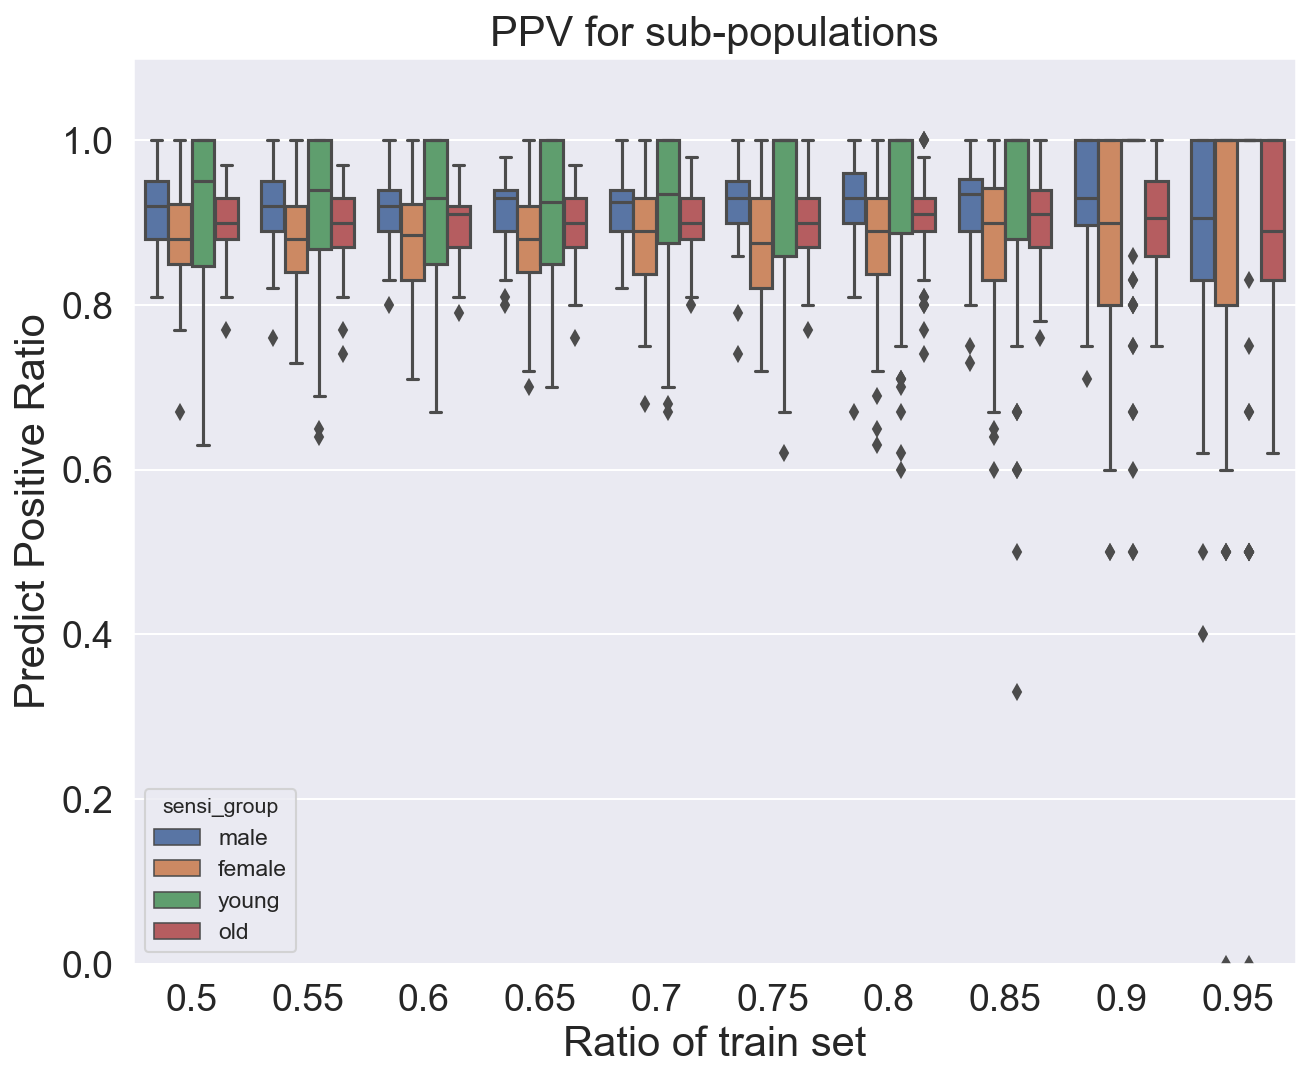

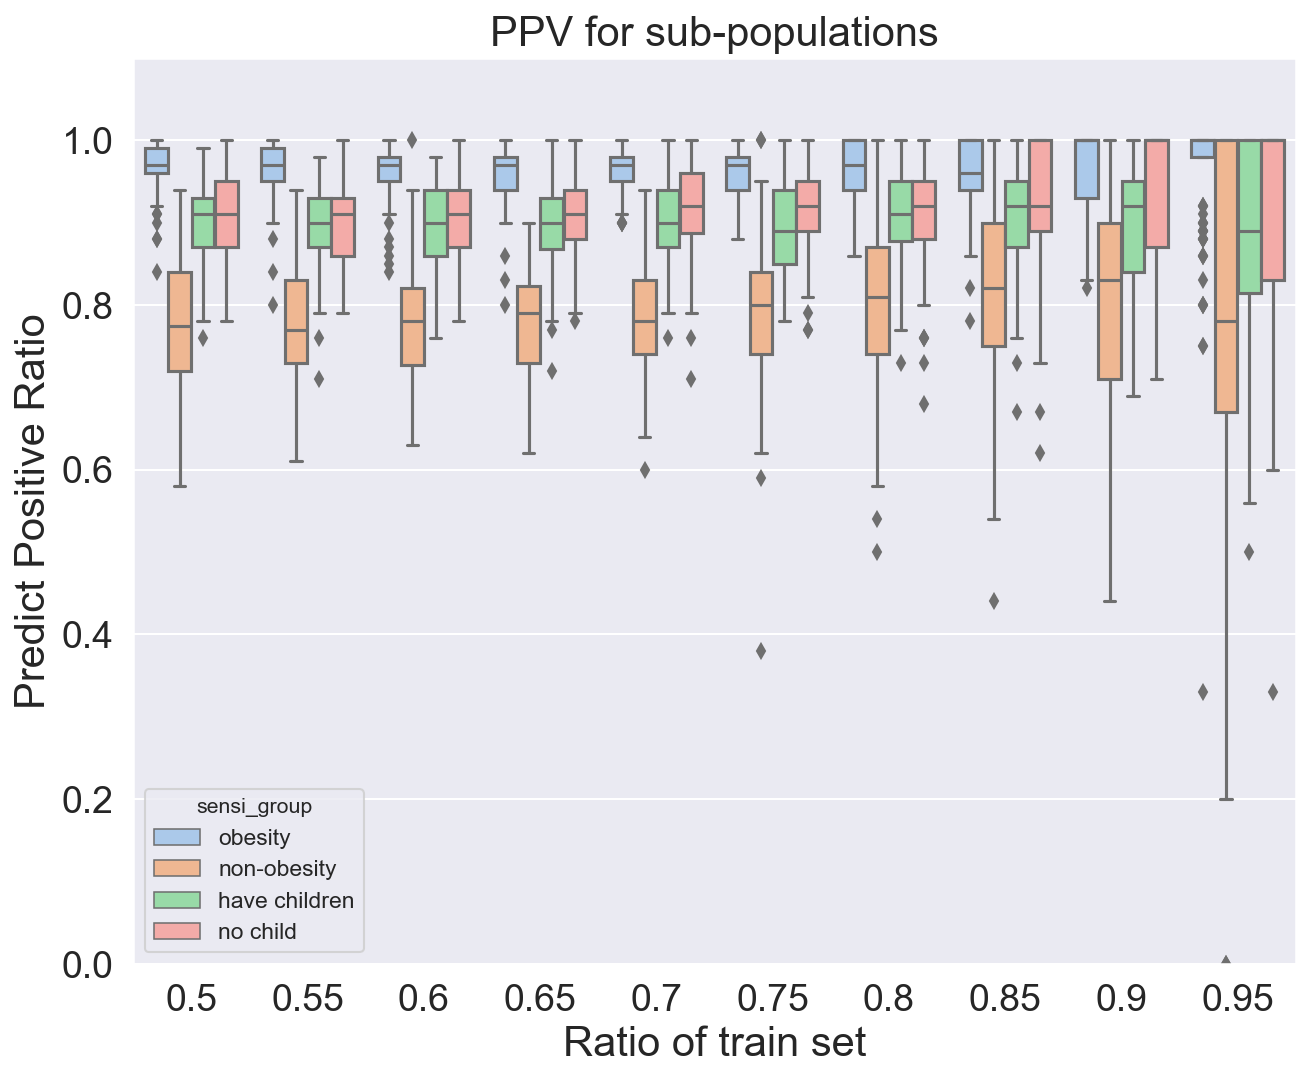

In [18]:
rf_gf_res = gf_res[(gf_res["regression_model"]=="random") & (gf_res["group_ppv"]!=-1)]
rf_gf_1 = rf_gf_res[rf_gf_res["sensi_att"].isin(["age", "sex"])]
rf_gf_2 = rf_gf_res[rf_gf_res["sensi_att"].isin(["bmi", "children"])]

plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="train_ratio", y="group_ppv", hue="sensi_group", data=rf_gf_1)
plt.xlabel("Ratio of train set", fontsize=20)
plt.ylabel("Predict Positive Ratio", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(pl_gf_res["group_ppv"]),1.1])
plt.title("PPV for sub-populations", fontsize=20)
plt.savefig("GF_rf_1.png")

plt.figure(figsize=[10,8],dpi=150)
sns.set(style="darkgrid")
sns.boxplot(x="train_ratio", y="group_ppv", hue="sensi_group", data=rf_gf_2, palette="pastel")
plt.xlabel("Ratio of train set", fontsize=20)
plt.ylabel("Predict Positive Ratio", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(pl_gf_res["group_ppv"]),1.1])
plt.title("PPV for sub-populations", fontsize=20)
plt.savefig("GF_rf_2.png")

# Diversity
- Diversity component shows the representation of different groups defined by the above sensitve attributes.
- We show the representations considering the instances categorized by the value of charge. The default charge threshold is 20000. When the true charge is greater or equal than 20000, we label this instance with positive.
- We show diversity analysis for positive and negative instances.

In [23]:
def binarize_data(_data):
    _data.loc[data["age"] < 25] = 1
    _data.loc[data["age"] >= 25] = 0
    _data.loc[data["bmi"] < 30] = 0
    _data.loc[data["age"] >= 30] = 1
    _data.loc[data["children"] > 0] = 1
    return _data
def get_predict_instance(_data, model_name="linear", y_threshold=20000, test_ratio=0.33, random_seed=0):
    data_train, data_test = train_test_split(_data, test_size=test_ratio, random_state=random_seed)
    if model_name == "linear":
        r_model = ADS.simpleLR(data_train)
        X_test, y_test = ADS.prepareLR(data_test)
        y_pred = r_model.predict(X_test)
    elif model_name == "polynomial":
        r_model = ADS.polynomialLR(data_train)
        X_test, y_test = ADS.preparePoly(data_test)
        y_pred = r_model.predict(X_test)
    else: # random forest
        r_model = ADS.forest(data_train)
        X_test, y_test = ADS.prepareForest(data_test)
        y_pred = r_model.predict(X_test)
    if model_name == "polynomial":
        pp_instance = [data_test.iloc[idx, :].name for idx, x in enumerate(y_pred) if x >= y_threshold]
        pn_instance = [data_test.iloc[idx, :].name for idx, x in enumerate(y_pred) if x < y_threshold] 
    else:
        pp_instance = [X_test.iloc[idx, :].name for idx, x in enumerate(y_pred) if x >= y_threshold]
        pn_instance = [X_test.iloc[idx, :].name for idx, x in enumerate(y_pred) if x < y_threshold]          
    bi_data_test = binarize_data(data_test)
    pos_data = bi_data_test[bi_data_test["charges"] >= y_threshold]
    neg_data = bi_data_test[bi_data_test["charges"] < y_threshold]
    predict_pos_data = bi_data_test.loc[pp_instance]
    predict_neg_data = bi_data_test.loc[pn_instance]
    return pos_data, predict_pos_data, neg_data, predict_neg_data
def visualize_diversity(_data, _att, _title_str, _y_col="charges"):
    sensi_group_map = {"sex":{0: "female", 1: "male"},
                       "age":{1: "young", 0: "old"},
                       "bmi":{1: "obesity", 0: "non-obesity"},
                       "children":{1: "have children", 0: "no child"},
                       "smoker":{1: "smoker", 0: "non-smoker"},
                       "region":{0: "northeast", 1: "northwest", 2: "southeast", 3: "southwest"}}
    plt.figure(figsize=[4,4],dpi=100)
    sns.set(font_scale = 1.5)
    sns.set_palette(palette="pastel")
    sort_data = _data.sort_values(by=_y_col, ascending=False)
    vis_count = sort_data[_att].value_counts()
    trans_label = [sensi_group_map[_att][x] for x in vis_count.index]
    plt.pie(list(vis_count.values), labels=trans_label, autopct='%1.1f%%');
    plt.title(_att+" ("+_title_str+")")
    plt.tight_layout()


## Linear Regression

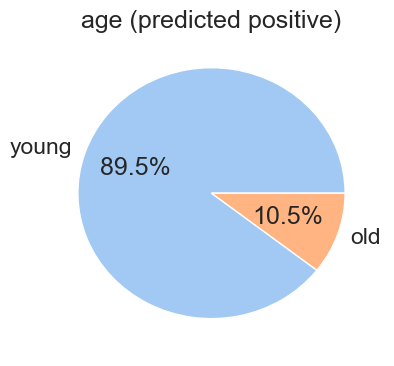

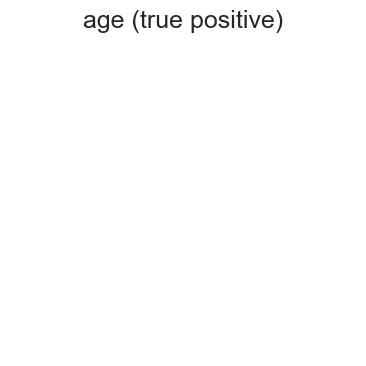

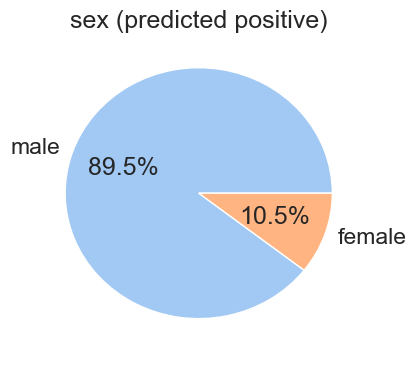

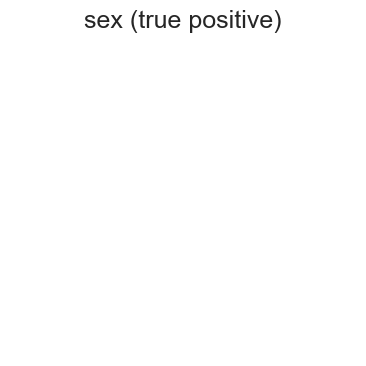

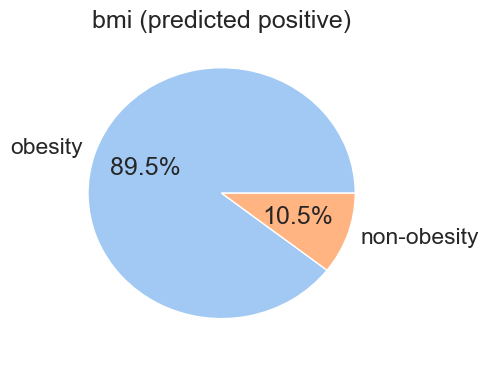

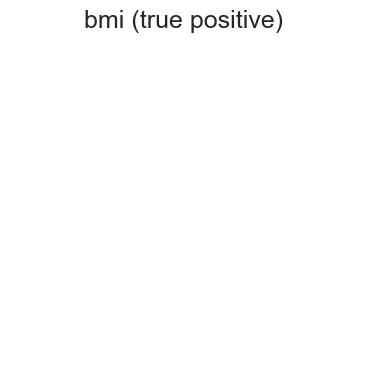

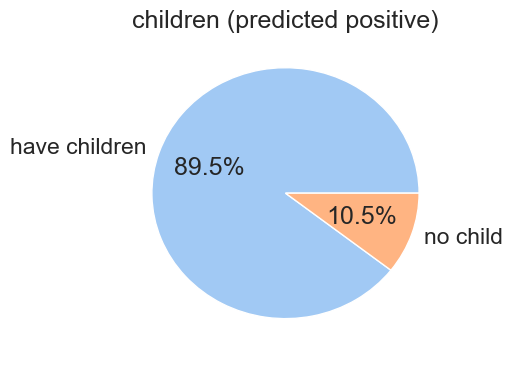

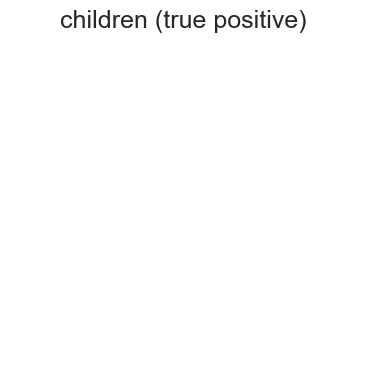

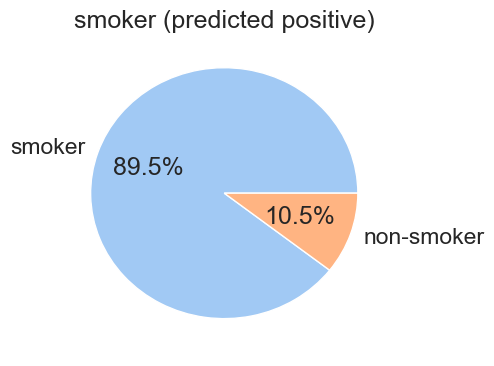

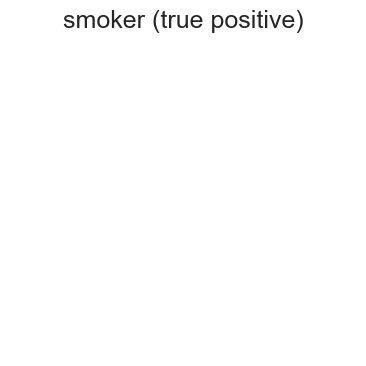

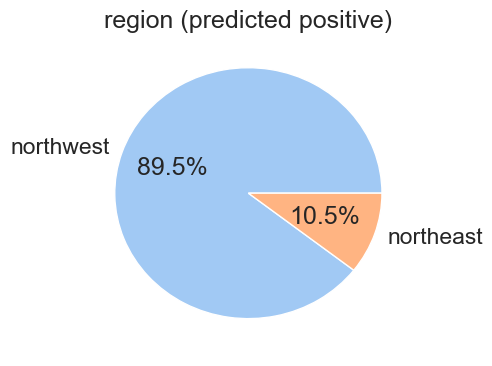

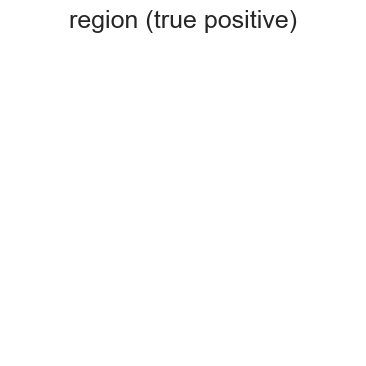

In [24]:
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
pos_data, predict_pos_data, neg_data, predict_neg_data = get_predict_instance(data, model_name="linear")
focus_att_list = list(data.columns[0:-1])
for ai in focus_att_list:
    visualize_diversity(predict_pos_data, ai, "predicted positive")
    visualize_diversity(pos_data, ai, "true positive")

## Polynomial Regression

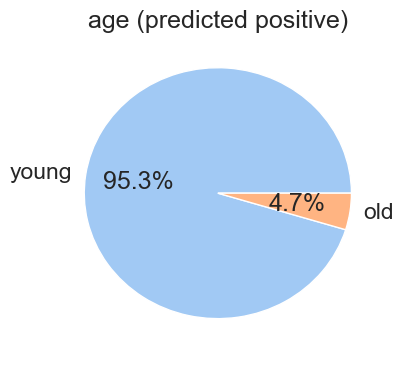

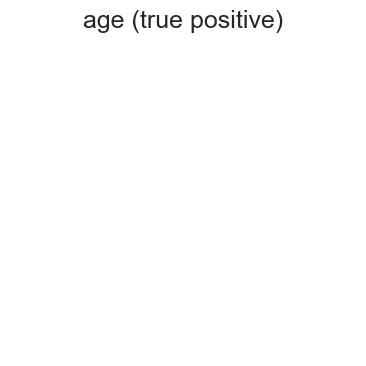

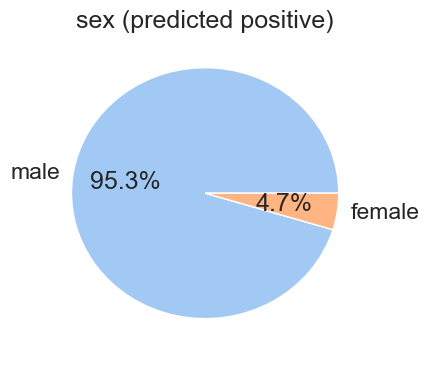

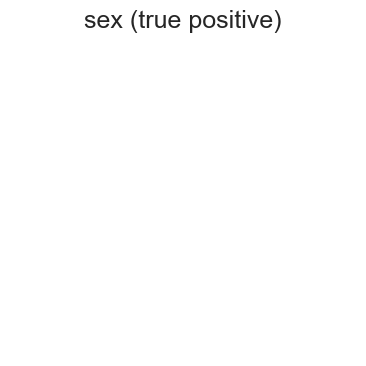

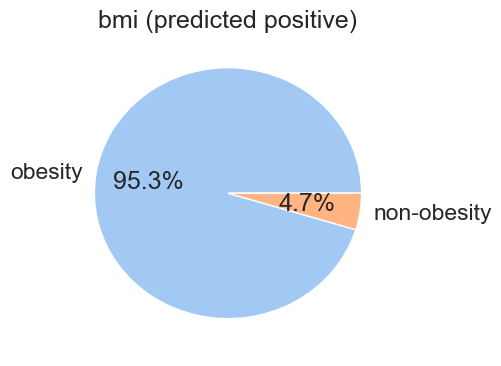

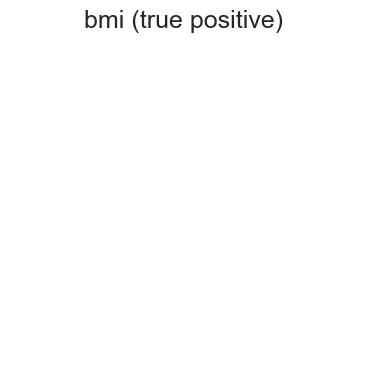

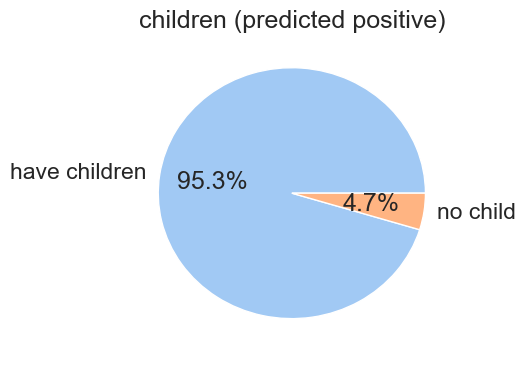

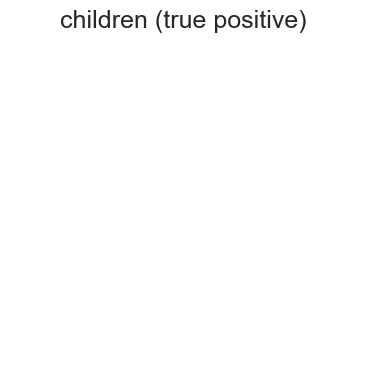

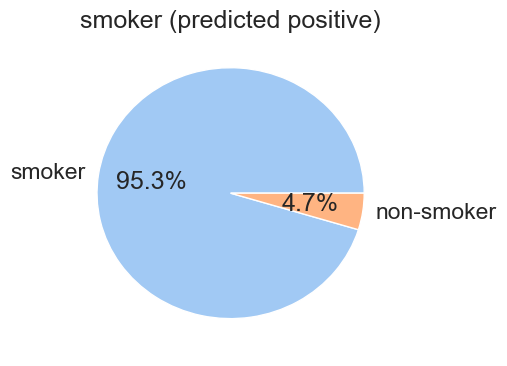

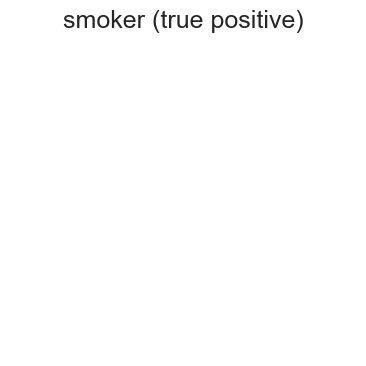

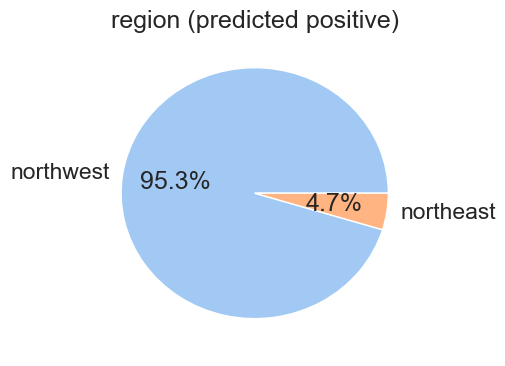

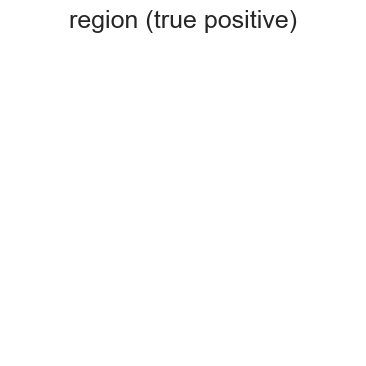

In [25]:
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
pos_data, predict_pos_data, neg_data, predict_neg_data = get_predict_instance(data, model_name="polynomial")
focus_att_list = list(data.columns[0:-1])
for ai in focus_att_list:
    visualize_diversity(predict_pos_data, ai, "predicted positive")
    visualize_diversity(pos_data, ai, "true positive")

## Random Forest

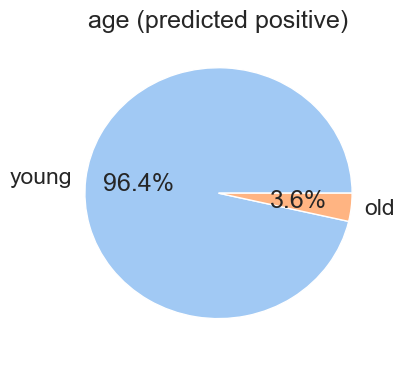

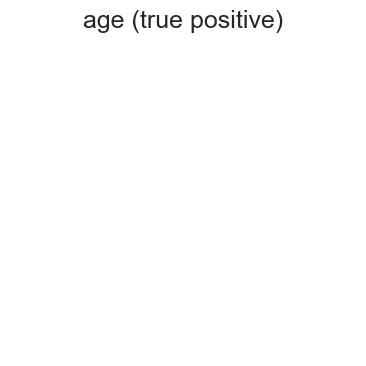

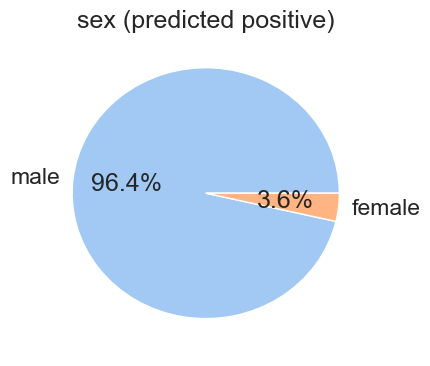

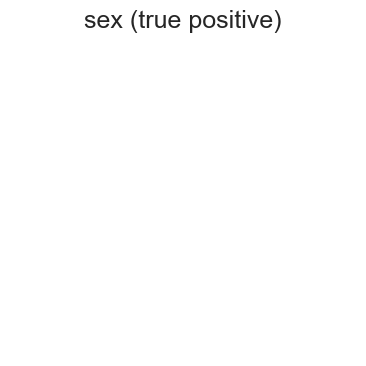

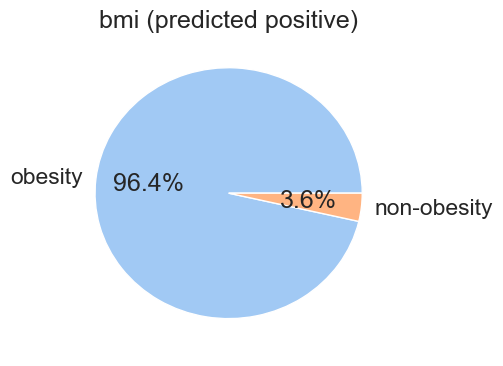

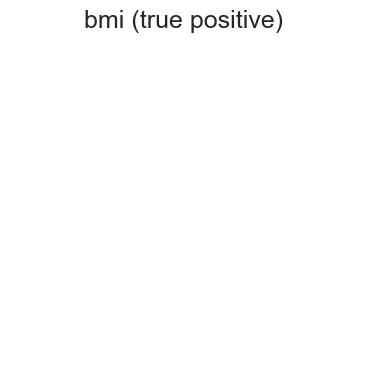

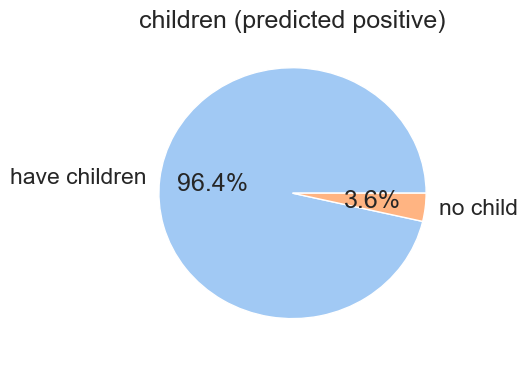

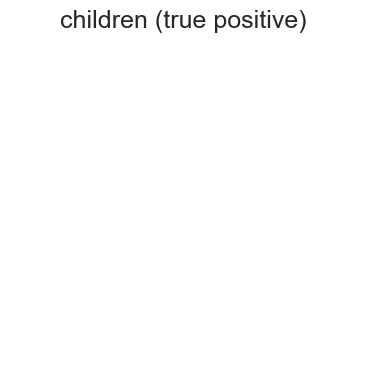

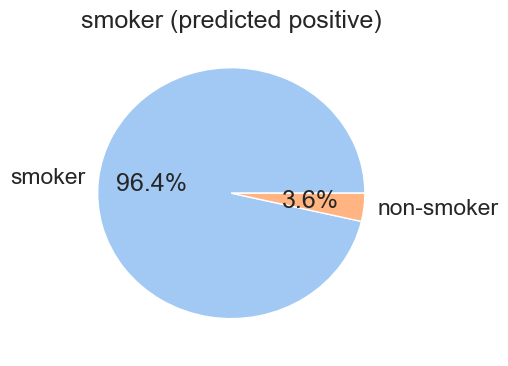

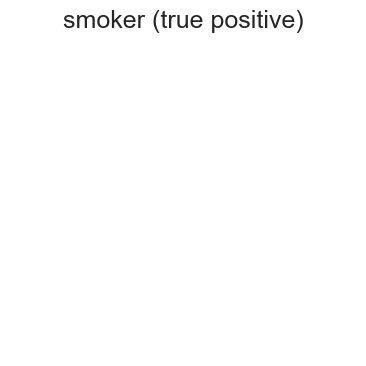

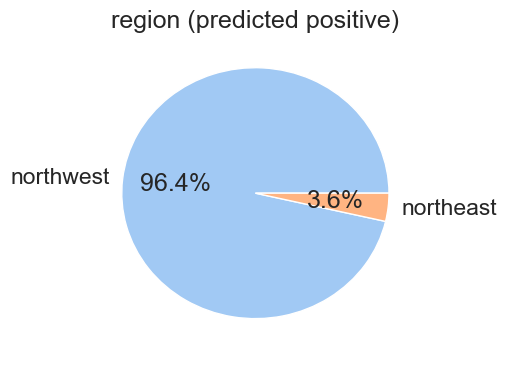

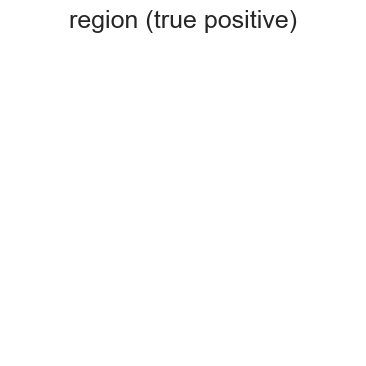

In [26]:
data = pd.read_csv("insurance.csv")
data = ADS.encode(data)
pos_data, predict_pos_data, neg_data, predict_neg_data = get_predict_instance(data, model_name="random")
focus_att_list = list(data.columns[0:-1])
for ai in focus_att_list:
    visualize_diversity(predict_pos_data, ai, "predicted positive")
    visualize_diversity(pos_data, ai, "true positive")